In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
import tensorflow as tf
import gymnasium as gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt


In [5]:
# Create the CartPole-v1 environment
env = gym.make("CartPole-v1", render_mode="human")

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))


Size of State Space ->  4
Size of Action Space ->  2


In [7]:
class ReplayBuffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer = deque(maxlen=self.buffer_capacity)

    def record(self, obs_tuple):
        self.buffer.append(obs_tuple)

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
        return np.array(state_batch), np.array(action_batch), np.array(reward_batch), np.array(next_state_batch), np.array(done_batch)

    def size(self):
        return len(self.buffer)

In [8]:
def build_q_network():
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(24, activation="relu")(inputs)
    out = layers.Dense(24, activation="relu")(out)
    outputs = layers.Dense(num_actions, activation="linear")(out)
    model = keras.Model(inputs, outputs)
    return model


In [10]:
def policy(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.choice(range(num_actions))
    q_values = q_network.predict(state)
    return np.argmax(q_values[0])



In [11]:
def update_q_network(state_batch, action_batch, reward_batch, next_state_batch, done_batch):
    q_values_next = target_q_network.predict(next_state_batch)
    q_values_next_max = np.amax(q_values_next, axis=1)
    targets = reward_batch + gamma * (1 - done_batch) * q_values_next_max

    q_values = q_network.predict(state_batch)
    for i in range(buffer.batch_size):
        q_values[i][action_batch[i]] = targets[i]

    q_network.train_on_batch(state_batch, q_values)

In [12]:
def update_target_network():
    target_q_network.set_weights(q_network.get_weights())

In [20]:
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
gamma = 0.99
tau = 0.005
learning_rate = 0.001
batch_size = 64
buffer_capacity = 50000
total_episodes = 100
target_update_steps = 50 # Update target network every 100 steps

In [21]:
# Initialize the Q-networks
q_network = build_q_network()
target_q_network = build_q_network()
target_q_network.set_weights(q_network.get_weights())

# Compile the Q-network
q_network.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='mse')


In [22]:
# Initialize the replay buffer
buffer = ReplayBuffer(buffer_capacity, batch_size)

# Store reward history of each episode
ep_reward_list = []
avg_reward_list = []

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Episode * 66 * Avg Reward is ==> 25.15
2/2 [==============================] - 0s 11ms/step
Episode * 67 * Avg Reward is ==> 26.1
2/2 [==============================] - 0s 6ms/step
Episode * 68 * Avg Reward is ==> 26.575
2/2 [==============================] - 0s 6ms/step
Episode * 69 * Avg Reward is ==> 30.05
2/2 [==============================] - 0s 5ms/step
Episode * 70 * Avg Reward is ==> 30.225
2/2 [==============================] - 0s 5ms/step
Episode * 71 * Avg Reward is ==> 30.2
2/2 [==============================] - 0s 7ms/step
Episode * 72 * Avg Reward is ==> 31.825
2/2 [==============================] - 0s 6ms/step
Episode * 73 * Avg Reward is ==> 32.025
2/2 [==============================] - 0s 5ms/step
Episode * 74 * Avg Reward is ==> 32.15
2/2 [==============================] - 0s 6ms/step
Episode * 75 * Avg Reward is ==> 33.45
2/2 [==============================] - 0s 8ms/

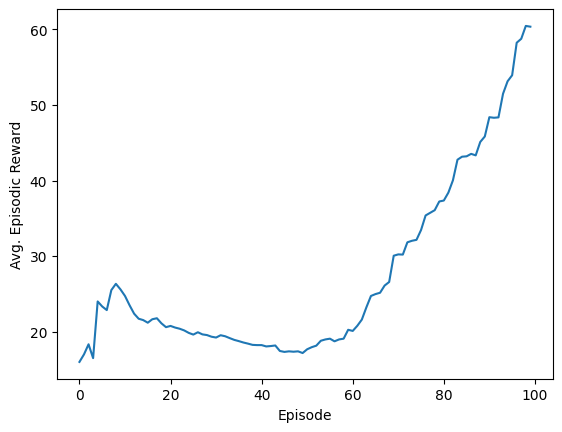

In [23]:
# Training loop
step = 0
for ep in range(total_episodes):
    state, _ = env.reset()
    state = np.expand_dims(state, axis=0)
    episodic_reward = 0

    while True:
        action = policy(state, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.expand_dims(next_state, axis=0)

        buffer.record((state, action, reward, next_state, done))
        episodic_reward += reward

        if buffer.size() >= batch_size:
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = buffer.sample()
            state_batch = np.squeeze(state_batch, axis=1)
            next_state_batch = np.squeeze(next_state_batch, axis=1)
            update_q_network(state_batch, action_batch, reward_batch, next_state_batch, done_batch)

            if step % target_update_steps == 0:
                update_target_network()
            step += 1

        state = next_state

        if done or truncated:
            break

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Plotting graph
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.show()